# Mandatory Assignment 2: Sampling Customers

**This is the second of three mandatory assignments to be handed in as part of the assessment for the course 02807 Computational Tools for Data Science at Technical University of Denmark, autumn 2019.**

#### Practical info
- **The assignment is to be done individually. You are under no circumstances allowed to collaborate with anyone on solving the exercises (cf. the full policy on this on the course website)**
- **You must hand in one Jupyter notebook (this notebook) with your solution**
- **The hand-in of the notebook is due 2019-11-10, 23:59 on DTU Inside**

#### Your solution
- **Your solution should be in Python**
- **You may use more cells than the provided ones for your answers**
- **You should not remove the problem statements**
- **Your notebook should be runnable, i.e., clicking [>>] in Jupyter should generate the result that you want to be assessed**

---
## Introduction
When computing group aggregates from a sample, simple random sampling does not give good results. Instead, a representative sample can be obtained by storing each record seen from a sample of the elements we group by. 

In this assignment you should implement this sampling method on a stream of customer spendings.

### Example
Suppose you are sampling from a stream of customer spendings. Each element of the stream consists of a customer ID and an amount. For example:

`123e4567-e89b-12d3-a456-426655440000 29.99`

To obtain a representative sample, you should sample some customer IDs and make sure that every occurrence of the sampled customer IDs are in your final sample. For example, if the customer ID `123e4567-e89b-12d3-a456-426655440000` is among the sampled customer IDs, every element with this ID should be in your sample. 

## Reading the stream
The following code reads a remote file line by line. It is wrapped in a generator to make it easier to extend. You should design your algorithm to read from the generator as a stream. You may extend or modify this to fit your requirements.

In [1]:
import urllib

def stream(n):
    i = 0
    with urllib.request.urlopen('https://files.dtu.dk/fss/public/link/public/stream/read/spending?linkToken=wkMPLdtDDyvQQw8o&itemName=spending') as f:
        for line in f:
            element = line.rstrip().decode("utf-8")
            yield element
            i += 1
            if i == n:
                break

In [2]:
STREAM_SIZE = 1000000
customer_stream = stream(STREAM_SIZE)

## Exercise 1
Implement an algorithm that computes a sample from the stream. The sample must be representative of customers, i.e., you should be able to answer group aggregate questions from it.

The sample size should be approximately 10% of the number of elements read from the stream.

It is important that your algorithm is a streaming algorithm. This means that your algorithm should update the sample every time an element from the stream is processed, and you should also only process the stream once.

### Hints
Hint 1: Since simple random sampling is not a good idea, you should not use the reservoir sampling algorithm.

Hint 2: The sample does not have to be exactly $k$ elements.

Hint 3: You should use a hash function and the fact that it can be used to uniformly map elements from a large universe to a smaller domain. Murmurhash3 (`mmh3`) is a suitable hash function from strings to integers for this.

In [3]:
import mmh3
import numpy as np

# Compute average price for customers
def compute_avg(customer, price, prev_avg, n, k_array, seeds = [13, 65, 41]):
    new = False
    k = 0 # Row number for 'k_array'
    for seed in seeds: # One seed per 'k_array' row
        idx = mmh3.hash(customer, seed=seed, signed=False) % len(k_array[0])
        if k_array[k][idx]==0: # New customer
            k_array[k][idx] = 1
            new = True
        k += 1
    if new: # New customer
        return ((prev_avg * n + float(price)) / (n + 1)), (n + 1), k_array
    else: # Existing customer
        return ((prev_avg * n + float(price)) / n), n, k_array

In [4]:
# Initializing variables
avg = 0 # Average value
num = 0 # Number of different customers
k_array = np.zeros((3,1000)) # 3x1000 array for the Bloom Filter

# Reading stream
for item in customer_stream:
    [customer, price] = item.split()
    if (mmh3.hash(customer, seed=37, signed=False) % 10)==0: # Processing only 10% of the customers
        avg, num, k_array = compute_avg(customer, price, avg, num, k_array)

<span style="color:DarkBlue">The function *compute_avg()* implements a Bloom Filter with 3 k-arrays of 1000bits. The average is updated everytime the function is called (for some customer belonging to the 10% stream sample). The Bloom Filter is used to identify if a customer is new or not. Each k-array is accessed and modified using Murmurhash3 as a hash function (with the customer identifier as input) with a different seed for each one. If a customer exists all the 3 k-arrays must contain a 1 in the positions obtained computing the customer identifier with the three hash functions mentioned.

## Exercise 2
Use the sample obtained in the previous exercise to answer the following question.

- What is the average total spending per customer?

In [5]:
print("The average total spending per customer is " + str(round(avg, 2)))

The average total spending per customer is 137269.14


## Exercise 3
Explain why simple random sampling would not give as good an answer to the question in exercise 2 as your new algorithm does.

Hint: Look at the distribution of amounts for some customer in your sample.

In [6]:
import matplotlib.pyplot as plt

STREAM_SIZE = 1000
customer_stream = stream(STREAM_SIZE)

In [7]:
# Reading stream
count = {} # Number of purchases per customer
amount = {} # Amount spent per customer
for item in customer_stream:
    [customer, price] = item.split()
    if customer not in count.keys():
        count[customer] = 1
        amount[customer] = float(price)
    else:
        count[customer] += 1
        amount[customer] += float(price)

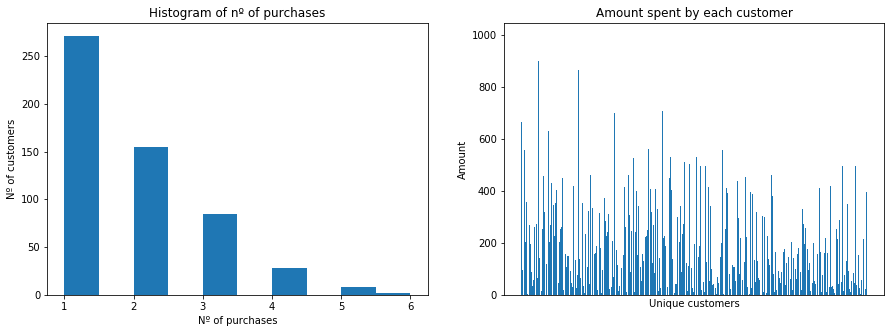

In [8]:
# Plotting some data from the stream
plt.figure(figsize=(15,5))
plt.subplot(1, 2, 1)
plt.hist(list(count.values()), )
plt.title("Histogram of nº of purchases")
plt.xlabel("Nº of purchases")
plt.ylabel("Nº of customers")
plt.subplot(1, 2, 2)
plt.bar(list(amount.keys()), list(amount.values()))
plt.xticks([])
plt.title("Amount spent by each customer")
plt.xlabel("Unique customers")
plt.ylabel("Amount")
plt.show()

<span style="color:DarkBlue">It can be checked in the upper plots that the total amount spent by each customer is very different and also the number of purchases made by each of them. Performing a random sampling is nice to compute the average amount for each purchase, but it's not a good choice to compute other statistics as the average total spending per customer. To calculate statistics for each customer it's necessary to track all the purchases for a representative group of customers. In this assigment 10% of customers from the stream have been selected and all their purchases have been taken into account.